In [1]:
%matplotlib inline

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.00298222  0.00257952 ...,  0.00230454  0.0025256   0.        ]
 [ 0.          0.00680859  0.00589684 ...,  0.00323842  0.00288753  0.        ]
 ..., 
 [ 0.          0.06429785  0.11279683 ...,  0.06202925  0.11588951  0.        ]
 [ 0.          0.08467624  0.00870733 ...,  0.09273338  0.07020751  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


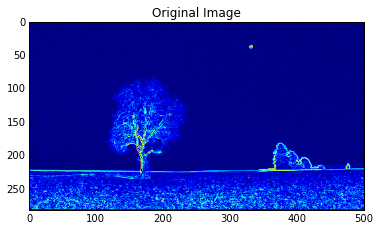

In [2]:
from skimage import data, draw,color, data, restoration
from skimage import transform, util
import numpy as np
from skimage import filters, color
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import matplotlib.animation as animation
from scipy.misc import imresize
from scipy import ndimage as nd


img =  plt.imread('countryside.jpg')

img = util.img_as_float(img)
grad = filters.sobel(color.rgb2gray(img))
print grad
plt.title('Original Image')
plt.imshow(grad)

In [3]:
#normalitzacio d'imatge
def normalitzar(image):
    return np.real((image - np.min(image)) * 256 / (np.max(image) - np.min(image)))

In [4]:

#Calcul matriu d'energia que te cada zona
def energia(im):
    height,width = im.shape
    energia=np.zeros(im.shape)
    #asignem la primera linea igual que la imatge que tenim
    energia[0]=im[0]   
    for x in range(1,height):
        for y in range(0,width):
            if y == 0:
                min_val = min( energia[x-1, y], energia[x-1, y+1] )
            elif y < width - 2:
                min_val = min( energia[x-1, y], energia[x-1, y+1] )
                min_val = min( min_val, energia[x-1, y-1] )
            else:
                min_val = min( energia[x-1, y], energia[x-1, y-1] )
            energia[x,y] = im[x,y] + min_val
    return energia
            
    
    

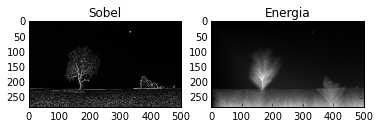

In [5]:
E = energia(grad)
#print energy
plt.subplot(1,2,1)
plt.imshow(normalitzar(grad), cmap="gray")
plt.title('Sobel')
plt.subplot(1,2,2)
plt.imshow(normalitzar(E), cmap="gray" )
plt.title('Energia')



In [64]:
# El calcul del tall vertical hem de buscar el cami amb cost minim. BACKTRACKING
# Aquest tall pot ser vertical o horitzontal, es un camí de pixels connectats. En el nostre cas l'apliquem vertical
# La función de importancia / energía valora un píxel mediante la medición de su contraste con sus píxeles vecinos.
# Des de la imatge en escala de grisos retornarem el tall vertical mes baix com a llista de pixels

def tall_vertical(fila, column, imatge, llista):
    if fila == 0: return llista
    
    # Mirem quin es el minim i l'asignem a variable fila i column
    if column == 0:
        min_val = min( imatge[fila-1, column], imatge[fila-1, column+1] )
    elif column < imatge.shape[1] - 2:
        min_val = min( imatge[fila-1,column-1], imatge[fila-1,column] )
        min_val = min( min_val, imatge[fila-1,column+1] )
    else:
        min_val = min( imatge[fila-1, column], imatge[fila-1, column-1] )
    
    if min_val == imatge[fila-1, column-1]:
        column = column - 1
    elif min_val == imatge[fila-1, column+1]:
        column = column + 1
          
    print tall_vertical(fila-1, column, imatge, llista)
    print "valor", imatge[fila, column]
    return [fila, column]    

h, w = E.shape
print 
linia = E[h-1]
pos = np.where(linia == min(linia))
llistaPos = []
print tall_vertical(h, 200, E, llistaPos)



[]
valor 0.00199859834102
[1, 262]
valor 0.00395982560295
[2, 263]
valor 0.00564805652675
[3, 264]
valor 0.0053715383325
[4, 265]
valor 0.00550954368689
[5, 265]
valor 0.0108704855325
[6, 266]
valor 0.0138459584679
[7, 267]
valor 0.0167215252662
[8, 268]
valor 0.0153530809778
[9, 267]
valor 0.0159175013254
[10, 267]
valor 0.0170072556309
[11, 267]
valor 0.0192709992992
[12, 268]
valor 0.0228035778304
[13, 269]
valor 0.0250514700489
[14, 270]
valor 0.0278926215114
[15, 269]
valor 0.0258030663355
[16, 268]
valor 0.0278308251205
[17, 268]
valor 0.0307041599591
[18, 268]
valor 0.0287635131893
[19, 267]
valor 0.0346067050827
[20, 267]
valor 0.0370446271184
[21, 266]
valor 0.0398301645309
[22, 265]
valor 0.0397564424007
[23, 266]
valor 0.0400652892397
[24, 265]
valor 0.042838257009
[25, 265]
valor 0.042838257009
[26, 265]
valor 0.0438140643671
[27, 266]
valor 0.0470693644623
[28, 267]
valor 0.048993609132
[29, 268]
valor 0.0508338052104
[30, 268]
valor 0.0535882613567
[31, 267]
valor 0.0550

IndexError: index 281 is out of bounds for axis 0 with size 281

In [ ]:
#ALGORITHM try(v1,...,vi)
#   IF (v1,...,vi) is a solution THEN RETURN (v1,...,vi)
#   FOR each v DO
#      IF (v1,...,vi,v) is acceptable vector  THEN
#        sol = try(v1,...,vi,v)
#        IF sol != () THEN RETURN sol
#      END
#   END
#   RETURN () 